## Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

# Multiprocessing
import multiprocessing
from joblib import parallel_backend, Parallel, delayed
num_cores = multiprocessing.cpu_count()

import glob
from sklearn.model_selection import train_test_split

import random
import time

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../utilities')

import utilities as util
import augmentations as aug

## Model Creation

We create a UNET Model that takes a binned image that has a size of 128x160 (originally 512x640)

In [4]:
import jax
from jax import jit, vmap, pmap, grad , numpy as jnp

from flax import linen as nn
from flax.training import train_state
import optax

from typing import Any, Callable, Sequence, Tuple

class DoubleConvBlock(nn.Module):
    input_channels: int = 128
    kernel_size: Tuple[int, int] = (3 ,3)

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.input_channels, kernel_size=self.kernel_size , padding='SAME')(x)
        x = nn.relu(x)
        x = nn.Conv(features=self.input_channels, kernel_size=self.kernel_size , padding='SAME')(x)
        x = nn.relu(x)
        return x

class DownBlock(nn.Module):
    input_channels: int = 128

    @nn.compact
    def __call__(self, x):
        conv = DoubleConvBlock(self.input_channels)(x)
        x = nn.max_pool(conv, window_shape=(2,2), strides=(2,2), padding='SAME')
        return x , conv

class ExpansiveBlock(nn.Module):
    input_channels: int = 128

    @nn.compact
    def __call__(self, x , skip_connection):
        x = jax.image.resize(image=x, shape=(x.shape[0] , skip_connection.shape[1] , skip_connection.shape[2] , x.shape[3] ), method="nearest")
        x = jnp.concatenate([x ,skip_connection],axis=-1)
        x = DoubleConvBlock(self.input_channels)(x)
        return x


class CIRRUS_Net(nn.Module):
    input_channels: Sequence[int]
    bottle_neck_conv: int = 512
    output_channel: int=1
    @nn.compact
    def __call__(self, x):

        skip_outputs = []
        for conv_layer in self.input_channels:
            x , conv = DownBlock(conv_layer)(x)
            skip_outputs.append((conv_layer , conv))

        #x = nn.Conv(self.bottle_neck_conv, kernel_size=(3, 3))(x)
        #x = nn.relu(x)
        #x = jax.image.resize(x, (x.shape[0] * 2, x.shape[1] * 2, x.shape[2]) , method="nearest")

        for i , (unconv_layer , skip_output)  in enumerate(reversed(skip_outputs)):
            x = ExpansiveBlock(unconv_layer)(x,skip_output)

        x = nn.Conv(self.output_channel, kernel_size=(3, 3), padding='SAME')(x)
        return x

We use a learning rate of 0.001 that decays using a Keras call back\
We use a BinaryCrossEntropy loss (log loss) which will classify each pixel as True or False (True meaning there is a cloud, False means there is no cloud)

In [14]:
def create_train_state(rng, input_shape, input_channels = [64 , 128, 256 , 512], bottle_neck_conv = 1024, learning_rate = 1e-3, total_steps = 10):
    model = CIRRUS_Net(input_channels, bottle_neck_conv)
    params = model.init(rng, jnp.ones(input_shape, dtype=jnp.float32))['params']
    # Initialize optimizer (Adam)
    cosine_decay_scheduler = optax.cosine_decay_schedule(learning_rate, decay_steps=total_steps, alpha=0.95)
    opt_adam = optax.adam(learning_rate=cosine_decay_scheduler)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=opt_adam)

@jit
def apply_model(state, images, labels):

    print("apply_model Compiled once")
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)

    probs = jax.nn.sigmoid(logits)
    # Round to get binary predictions
    preds = jnp.round(probs)
    # Compute accuracy for binary classification
    accuracy = jnp.mean(preds == labels)
    new_state = state.apply_gradients(grads=grads)

    return new_state, loss, accuracy

@jit
def apply_nograd(state, images, labels):

    logits = state.apply_fn({'params': state.params}, images)
    loss = jnp.mean(optax.sigmoid_binary_cross_entropy(logits=logits, labels=labels))

    probs = jax.nn.sigmoid(logits)
    # Round to get binary predictions
    preds = jnp.round(probs)
    # Compute accuracy for binary classification
    accuracy = jnp.mean(preds == labels)

    return  loss, accuracy

@jit
def predict(state, images):
    logits = state.apply_fn({'params': state.params}, images)
    probs = jax.nn.sigmoid(logits)
    return probs

## Preprocessing

### Data Loading and Preprocessing

For this image segmentation task, our data consists of FITS (Flexible Image Transport System) files.

### Opening and Preprocessing FITS files

Our `open_fits_with_mask` function performs the following tasks:

**File Opening:** Opens the provided `FITS` file using the `fits.open()` method.\
**Extracting Image and Mask:** The function retrieves the actual image data (cloud) and the corresponding segmentation mask.
Normalization: To bring the pixel values within a standard range, the cloud data is normalized using a given DR value.

In [6]:
DR = 2**14
def open_fits_with_mask(filename):
    image = fits.open(filename)
    cloud = image[0].data
    mask = image[1].data
    del image

    # Normalize image
    cloud  = cloud / DR
    return cloud , mask

### Loading the Dataset

**Retrieve File Paths:** We obtain a list of all FITS files present in our specified directory.\
**Shuffle the List:** To ensure randomness and avoid any inherent order bias, we shuffle our list of images.\
**Parallel Processing:** Leveraging the joblib library, we employ parallel processing to efficiently load all our FITS files using multiple cores.

In [7]:
images_list = glob.glob('/gdrive/MyDrive/Colab/CIRRUS/CIRRUS_DS/Seg/DS1_MASKED_SUBSET/*.fits')
images_list = random.choices(images_list, k=len(images_list))

with parallel_backend('threading', n_jobs=num_cores):
    l_fits = Parallel(verbose=0)(delayed(open_fits_with_mask)(filename=r) for r in images_list)
l_fits = np.array(l_fits)

### Quick Visual Inspection

To verify our data loading process and get a sense of our data, we randomly select three images from our dataset.
Display them using the util.plot_image function.

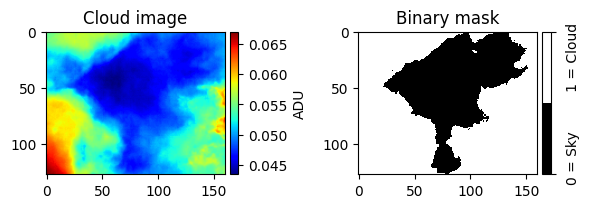

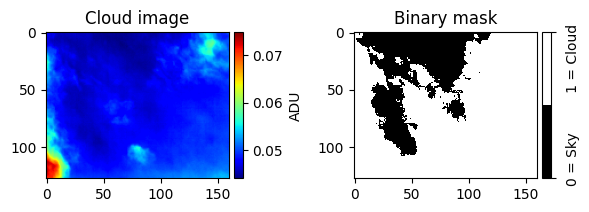

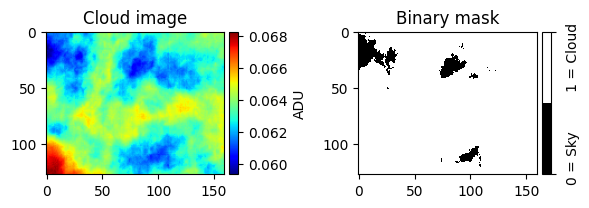

In [8]:
for _ in range(3):
    random_index = random.randint(0, len(l_fits) - 1)
    util.plot_image(data=l_fits[random_index] , figsize=(6,3))

## Data set gen and batching

Training a neural network requires input data in batches. The custom data generator, CloudImageDataGenerator, ensures smooth data flow during training by dividing the dataset into batches and feeding it into the model. This is particularly important when the dataset is too large to fit into memory.

### Data Augmentation on the fly

the data set generator is used to train on batches of images\
Each set of batch is augmented by a parameter `aug_batch_size`

### Loading data in Jax Numpy Array

The only difference between this loader and the keras loader is the fact that we add a dimension (represting the grayscale channel) for convolutions and we return directly Jax numpy arrays


In [9]:
# @title
class CloudImageDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_data, y_data, batch_size=8,aug_batch_size=2, shuffle=True):
        self.x_data = x_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.aug_batch_size = aug_batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x_data))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.x_data) / self.batch_size))

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_indices = self.indices[start_idx:end_idx]

        batch_x = self.x_data[batch_indices]
        batch_y = self.y_data[batch_indices]

        # Create a list of tuples using zip
        batch_list = list(zip(batch_x, batch_y))

        if self.aug_batch_size != 0:
            l_fits_aug = [aug.random_augment(img_mask=random.choice(batch_list)) for _ in range(self.aug_batch_size)]
            fits_images_aug = np.array(l_fits_aug)

            batch_x =  np.concatenate((batch_x, fits_images_aug[:,0]), axis=0)
            batch_y =  np.concatenate((batch_y, fits_images_aug[:,1]), axis=0)

        # Convert the TensorFlow tensors to JAX arrays
        batch_x = jnp.array(batch_x[..., np.newaxis])
        batch_y = jnp.array(batch_y[..., np.newaxis])

        return batch_x, batch_y


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

Split the data set into training and validation

In [10]:
# @title
X_train, X_test, y_train, y_test = train_test_split(l_fits[:,0], l_fits[:,1], test_size=0.2, random_state=42)

Load the dataset generator\
We choose not to augment the validation set because it does not make sense

In [11]:
# @title
ds_train_gen = CloudImageDataGenerator(x_data=X_train,y_data=y_train,batch_size=64,aug_batch_size=64, shuffle=True)
ds_val_gen = CloudImageDataGenerator(x_data=X_test,y_data=y_test,batch_size=64,aug_batch_size=0, shuffle=False)

# Training

In [12]:
# Initialize model
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)
input_shape = (24, 160, 128, 1)
unet_filters = [64 ,128, 256]
bottle_neck_conv = 1024
learning_rate  = 1e-3
state = create_train_state(init_rng, input_shape,unet_filters, bottle_neck_conv,learning_rate, len(ds_train_gen))
num_epochs = 50

In [18]:
v_apply_model = vmap(apply_model)
batch_per_epoch = len(ds_train_gen)
val_batch_per_epoch = len(ds_val_gen)

patience = 10  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Store the best validation loss
counter = 0  # Keep track of how many epochs have passed since last best validation loss


for epoch in range(num_epochs):

    train_loss = []
    train_accuracy = []

    start_time = time.time()
    for cnt , batch in enumerate(ds_train_gen):
        images, masks = batch

        state, loss, accuracy = apply_model(state, images, masks)
        train_loss.append(loss)
        train_accuracy.append(accuracy)

        if cnt % (batch_per_epoch // 5) == 0:
            avg_loss = jnp.mean(jnp.stack(train_loss))
            avg_accuracy = jnp.mean(jnp.stack(train_accuracy))
            #print(f"Batch Number {cnt + 1}/{batch_per_epoch} - Loss: {avg_loss}, Accuracy: {avg_accuracy}")

    test_losses = []
    test_accuracy = []
    for cnt, batch in enumerate(ds_val_gen):
        images, masks = batch

        loss, accuracy = apply_nograd(state,images,masks)
        test_losses.append(loss)
        test_accuracy.append(accuracy)

        if cnt % (val_batch_per_epoch // 5) == 0:
            avg_loss = jnp.mean(jnp.stack(test_losses))
            avg_accuracy = jnp.mean(jnp.stack(test_accuracy))
            #print(f"Valid Batch Number {cnt + 1}/{val_batch_per_epoch} - Loss: {avg_loss}, Accuracy: {avg_accuracy}")

    epoch_time = time.time() - start_time
    avg_loss = jnp.mean(jnp.stack(train_loss))
    avg_accuracy = jnp.mean(jnp.stack(train_accuracy))
    avg_val_loss = jnp.mean(jnp.stack(test_losses))
    avg_val_acc = jnp.mean(jnp.stack(test_accuracy))
    print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {avg_loss}, Accuracy: {avg_accuracy}, - val_Loss: {avg_val_loss}, val_Accuracy: {avg_val_acc},  Time taken: {epoch_time:.2f} seconds")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} out of {patience}")
        if counter >= patience:
            print("EarlyStopping: Stop training")
            break


Epoch 1/50 - Loss: 0.3715986907482147, Accuracy: 0.8175750970840454, - val_Loss: 0.3723563253879547, val_Accuracy: 0.8495481610298157,  Time taken: 13.49 seconds
Epoch 2/50 - Loss: 0.3719668686389923, Accuracy: 0.8204165697097778, - val_Loss: 0.36707574129104614, val_Accuracy: 0.8504325151443481,  Time taken: 12.44 seconds
Epoch 3/50 - Loss: 0.3739769160747528, Accuracy: 0.8181601762771606, - val_Loss: 0.37298884987831116, val_Accuracy: 0.8495481610298157,  Time taken: 12.29 seconds
EarlyStopping counter: 1 out of 10
Epoch 4/50 - Loss: 0.37445661425590515, Accuracy: 0.8183616995811462, - val_Loss: 0.3698696196079254, val_Accuracy: 0.8495481610298157,  Time taken: 12.49 seconds
EarlyStopping counter: 2 out of 10
Epoch 5/50 - Loss: 0.3742324113845825, Accuracy: 0.8144822120666504, - val_Loss: 0.3650834560394287, val_Accuracy: 0.8536824584007263,  Time taken: 12.50 seconds
Epoch 6/50 - Loss: 0.36530739068984985, Accuracy: 0.8215385675430298, - val_Loss: 0.3599563241004944, val_Accuracy: 0

In [21]:
# Initialize an empty list to store predictions
all_predictions = []

# Predict using batches
for batch in ds_val_gen:
    images, _ = batch  # Get next batch of images (ignoring masks)
    batch_predictions = predict(state, images)
    all_predictions.append(batch_predictions)

# Combine predictions from all batches
all_predictions = jnp.concatenate(all_predictions, axis=0)
y_pred = all_predictions.squeeze(axis=-1)

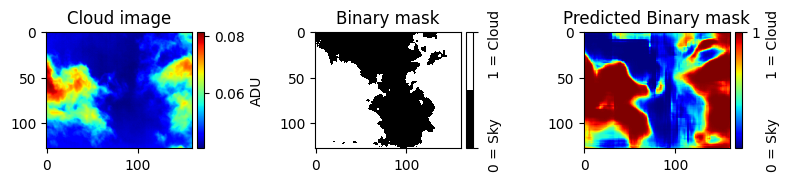

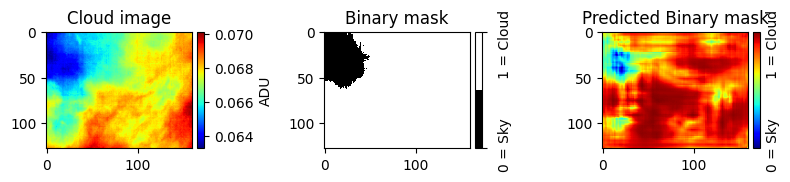

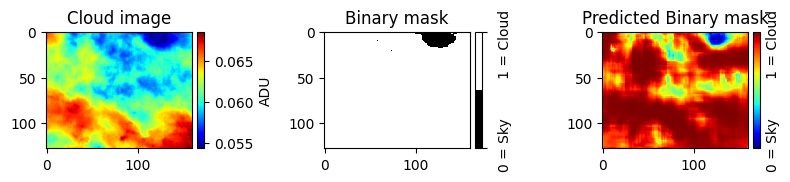

In [34]:
for _ in range(3):
    random_index = random.randint(0, len(X_test) - 1)
    util.plot_image_pred(X_test[random_index], y_test[random_index], y_pred[random_index],predmask_cmap='jet')

Mean Accuracy: 0.8919
Mean Precision: 0.9082
Mean Recall: 0.9708
BinaryCrossEntropy Loss: 0.2579
IOU: 0.8840


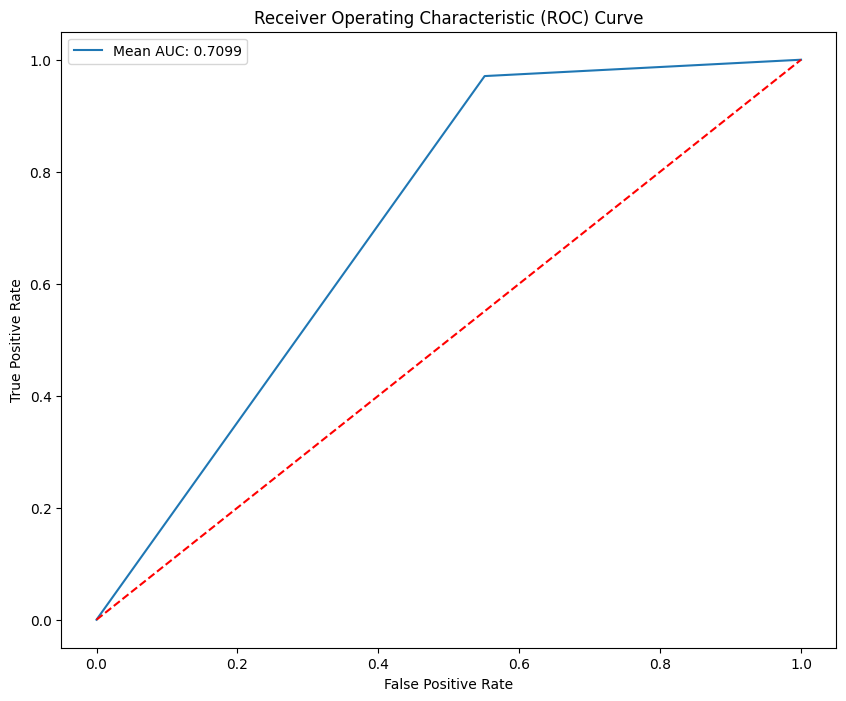

In [35]:
util.evaluate_model(y_test,y_pred)